In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import time
import urllib.request
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
#os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-23\bin\server'
#print('JAVA_HOME' in os.environ)

from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import holidays
import datetime
from dash import Dash, dcc, html, Input, Output

import warnings
warnings.filterwarnings('ignore')

In [6]:
# 모든 행과 열을 표시하도록 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# 출력 후 설정 원래대로 돌리기
# pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 네이버 블로그 크롤링

#### 관광지 이름 불러오기

In [4]:
name = pd.read_csv("../data/대전_관광지.csv")
name = name[['관광지명', '주소', '중심카테고리 명_대', '분류']]
place_names = name['관광지명']

#### 네이버 블로그 크롤링

In [5]:
# 웹 드라이버 설정
options = webdriver.ChromeOptions()
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

# 버전에 상관 없이 os에 설치된 크롬 브라우저 사용
driver = webdriver.Chrome()
driver.implicitly_wait(3)

# Naver API key 입력 : 현재 비식별화 처리 ->  Naver Developers에서 발급 가능
client_id = 'Xn3Yn**********ce2w3' 
client_secret = '*******_lM'

In [6]:
naver_urls = []
postdate = []
titles = []
data = []
place = []

# 기준 날짜를 2020년 1월 1일로 설정
filter_date = '20200101'

for name in place_names:
    # 검색어 입력 (대전 반드시 포함 / 제외 단어 필터링)
    encText = urllib.parse.quote(f"{name} + 대전 -부동산 -월세 -전세 -분양 -주택 -공주 -주차장 -코스 -여행")

    # 검색을 끝낼 페이지 입력
    end = 6
    # 한번에 가져올 페이지 입력
    display = 100

    count = 0
    for start in range(end):
        url = "https://openapi.naver.com/v1/search/blog?query=" + encText + "&start=" + str(start+1) + "&display=" + str(display) # JSON 결과
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id", client_id)
        request.add_header("X-Naver-Client-Secret", client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
    
        if rescode == 200:
            response_body = response.read()
            crawling = json.loads(response_body.decode('utf-8'))['items']
    
            for row in crawling:
                post_date = row['postdate']
                if post_date >= filter_date and 'blog.naver' in row['link']:
                    row['place'] = name
                    naver_urls.append(row['link'])
                    postdate.append(post_date)
                    place.append(name)
                
                    # html태그 제거
                    title = row['title']
                    pattern1 = '<[^>]*>'
                    title = re.sub(pattern=pattern1, repl='', string=title)
                    titles.append(title)
                
                    data.append(row)
                    count += 1  # 조건에 맞는 게시물 카운트 증가
                
                    if count >= 50:  # 50개를 넘기지 않도록 제한
                        break
            
            if count >= 50:
                break
            time.sleep(2)  # API 호출 간 딜레이
        else:
            print("Error Code:" + str(rescode))

    print(f"{name}, {count}개 크롤링 완료")
    


#### 블로그 글을 blog.csv로 저장

In [7]:
# HTML 태그 제거 함수 정의
def remove_html_tags(text):
    pattern = '<[^>]*>'
    return re.sub(pattern, '', text)

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

contents = []
comments_texts = []
try:
    for i in naver_urls:
        print(i)
        driver.get(i)
        time.sleep(3)  # 대기시간

        iframe = driver.find_element(By.ID , "mainFrame") 
        driver.switch_to.frame(iframe)

        source = driver.page_source
        html = BeautifulSoup(source, "html.parser")
        
        # 기사 텍스트만 가져오기
        content = html.select("div.se-main-container")
        #  list합치기
        content = ''.join(str(content))

        # html태그제거 및 텍스트 다듬기
        content = re.sub(pattern=pattern1, repl='', string=content)
        pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
        content = content.replace(pattern2, '')
        content = content.replace('\n', '')
        content = content.replace('\u200b', '')
        contents.append(content)


    news_df = pd.DataFrame({'place': place, 'title': titles, 'content': contents, 'date': postdate})
    news_df['content'] = news_df['content'].apply(remove_html_tags)
    #news_df.to_csv('blog.csv', index=False, encoding='utf-8-sig')
except:
    contents.append('error')
    news_df = pd.DataFrame({'place': place, 'title': titles, 'content': contents, 'date': postdate})
    news_df['content'] = news_df['content'].apply(remove_html_tags)
    #news_df.to_csv('blog.csv', index=False, encoding='utf-8-sig')

### 블로그글 전처리

#### 블로그글 불러오고 형태소분석

In [2]:
blog = pd.read_csv("../data/result/blog.csv")

# 관광지별로 형태소 분석할 수 있도록 하나의 문장으로 합치기
blog['content'] = blog['content'].astype(str)
blog = blog.groupby('place')['content'].agg(' '.join).reset_index()

# 한글, 영어, 숫자, 공백만 남기고 나머지 문자 제거
blog['content'] = blog['content'].apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', x))

In [3]:
okt = Okt()
blog['word'] = blog['content'].apply(lambda x: okt.pos(x, norm=True, stem=True))

# 명사와 형용사만 남기기
token = pd.Series()
noun = pd.Series()
verb = pd.Series()
adjective = pd.Series()

for i in range(len(blog['word'])):
    word_list = []
    noun_list = []
    verb_list = []
    adjective_list = []
    for t in blog['word'][i]:
        if t[1] == 'Noun':
            noun_list.append(t[0])
        if t[1] == 'Verb':
            verb_list.append(t[0])
        if t[1] == 'Adjective':
            adjective_list.append(t[0])
        if t[1] in ['Noun', 'Verb', 'Adjective']:
            word_list.append(t[0])
    
    token[i] = word_list
    noun[i] = noun_list
    verb[i] = verb_list
    adjective[i] = adjective_list

# 새로운 열로 추가
blog['token'] = token
blog['noun'] = noun
blog['verb'] = verb
blog['adjective'] = adjective

blog.head()

,place,content,word,token,noun,verb,adjective
0,대전근현대사전시관,현재 대전에서 진행하고 있는 대전0시축제작년에도 했던거같은데 사실축제가 가볼생각을 ...,"[(현재, Noun), (대전, Noun), (에서, Josa), (진행, Noun...","[현재, 대전, 진행, 있다, 대전, 하다, 같다, 사실, 축제, 가보다, 생각, ...","[현재, 대전, 진행, 대전, 사실, 축제, 생각, 전혀, 대전, 근현대사, 전시관...","[하다, 가보다, 하다, 않다, 하다, 하다, 보다, 되다, 하다, 두다, 해봤다,...","[있다, 같다, 가깝다, 덥다, 힘드다, 많다, 솔깃하다, 없다, 있다, 수월하다,..."
1,대전목재문화체험장,대전 아이와 함께 가볼만 한 곳 추천 대전 목재문화 체험장예전에 우연히 보고 애들...,"[(대전, Noun), (아이, Noun), (와, Josa), (함께, Adver...","[대전, 아이, 가보다, 하다, 곳, 추천, 대전, 목재, 문화, 체험, 예전, 보...","[대전, 아이, 곳, 추천, 대전, 목재, 문화, 체험, 예전, 보고, 애, 것, ...","[가보다, 하다, 가보다, 하다, 좋아지다, 하다, 가보다, 싶다, 하다, 들어가다...","[좋다, 같다, 어떻다, 있다, 가능하다, 있다, 좋다, 같다, 가능하다, 자세하다..."
2,대전보훈공원,호국보훈의 달인 6월6월에는 가장 먼저 현충일이 다가오는데요 우리 아이들도 현충일이...,"[(호국보훈, Noun), (의, Josa), (달인, Noun), (6월, Num...","[호국보훈, 달인, 가장, 먼저, 현충일, 다가오다, 우리, 아이, 현충일, 달력,...","[호국보훈, 달인, 가장, 먼저, 현충일, 우리, 아이, 현충일, 달력, 표시, 날...","[다가오다, 되다, 하다, 하다, 가지다, 가다, 보다, 하다, 드리다, 보이다, ...","[빨갛다, 어떻다, 이다, 있다, 특별하다, 있다, 참혹하다, 자세하다, 있다, 생..."
3,대전아쿠아리움,아이랑 가볼만한 곳대전 신세계 아쿠아리움 한번 가야지 가야지 하다가 드디어 가...,"[(아이, Noun), (랑, Josa), (가보다, Verb), (한, Deter...","[아이, 가보다, 곳, 대전, 신세계, 아쿠아리움, 한번, 가야, 가야, 하다, 가...","[아이, 곳, 대전, 신세계, 아쿠아리움, 한번, 가야, 가야, 대전, 신세계, 아...","[가보다, 하다, 가보다, 하다, 올라오다, 하다, 들어가다, 크다, 안다, 꾸미다...","[이다, 있다, 있다, 예쁘다, 있다, 있다, 신기하다, 재밌다, 있다, 예쁘다, ..."
4,대전예술가의집,대전테미예술창작센터가 개최한 11기 입주예술가 개인전을 다녀왔습니다 이번 전시는 대...,"[(대, Modifier), (전, Modifier), (테미, Noun), (예술...","[테미, 예술, 창작, 센터, 개최, 기, 이다, 예술가, 개다, 다녀오다, 이번,...","[테미, 예술, 창작, 센터, 개최, 기, 예술가, 이번, 전시, 예술가, 집, 전...","[개다, 다녀오다, 되어다, 담기다, 선보이다, 되어다, 하다, 하다, 되어다, 이...","[이다, 이다, 있다, 아니다, 이다, 이다, 이다, 있다, 이다, 있다, 있다, ..."


TfidfVectorizer을 쓰려면 하나의 문장으로 있어야 하기 때문에 토큰들을 합침

In [4]:
blog_df = blog.copy()
blog_df['token'] = blog_df['token'].apply(lambda x: ' '.join(x))
blog_df['noun'] = blog_df['noun'].apply(lambda x: ' '.join(x))
blog_df['verb'] = blog_df['verb'].apply(lambda x: ' '.join(x))
blog_df['adjective'] = blog_df['adjective'].apply(lambda x: ' '.join(x))

#### 불용어 제거

In [5]:
# 불용어 제거 함수
def remove_stopwords(text):
    tokens = text.split(' ')
    okt = Okt()
    all_place = []
    for place in blog_df['place']:
        token_place = okt.morphs(place)
        all_place.extend(token_place)

    stopwords = ['계속', '다음', '도국', '대전', '대전광역시', '동시', '바로', 
                 '번길', '안함', '여기', '오늘', '우리', '위해', '이번', '정말', 
                 '진짜', '갈다', '기다', '나다', '내다', '대다', '돼다', '되다', 
                 '되어다', '맞다', '말다', '모르다', '싶다', '써다', '않다', '이다', 
                 '하다', '해주다', '해드리다',  '같다', '그렇다', '아니다', '안되다', 
                 '안녕하다', '어떻다', '없다', '의하다', '이다', '이렇다', '있다', 
                 '인하다', '자리다']
    
    stopwords.extend(all_place)
    stopwords = list(set(stopwords))

    meaningful_words = [w for w in tokens if not w in stopwords]
    return ' '.join(meaningful_words)

blog_df["token"] = blog_df["token"].map(remove_stopwords)

### 군집분석

#### tf-idf 행렬

In [6]:
vectorizer = TfidfVectorizer(max_features=300)
tfidf_matrix = vectorizer.fit_transform(blog_df['token'])
# 결과 출력
pd.DataFrame(tfidf_matrix.toarray())
word = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=word, index=blog_df['place'])

# 표준화
scaler = MinMaxScaler()
tfidf_scaled = scaler.fit_transform(tfidf_df)

# 표준화된 데이터를 데이터프레임으로 변환하고 인덱스 설정
tfidf_scaled = pd.DataFrame(tfidf_scaled, columns=tfidf_df.columns, index=tfidf_df.index)

#### K-Means 군집분석

##### Elbow Method & SiSilhouette Score으로 군집 수 결정

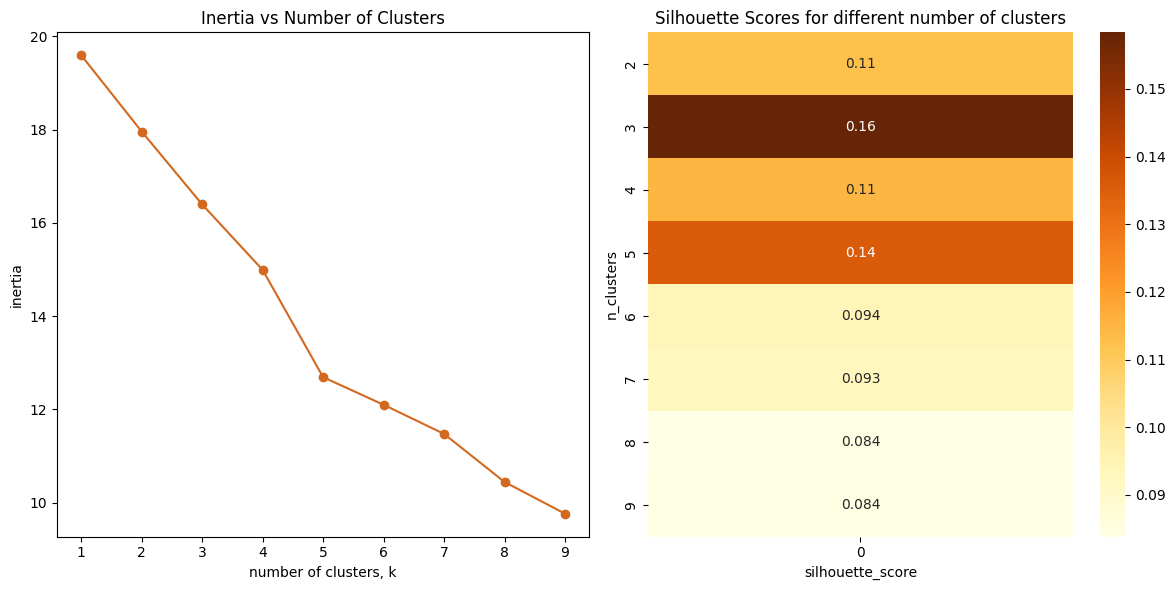

In [7]:
# KMeans Inertia 계산
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, random_state=3)
    model.fit(tfidf_df)
    inertias.append(model.inertia_)

# Silhouette Score 계산
silhouette_scores = []
cluster_range = range(2, 10)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    labels = kmeans.fit_predict(tfidf_df)
    silhouette_avg = silhouette_score(tfidf_df, labels)
    silhouette_scores.append(silhouette_avg)

# 실루엣 스코어를 배열로 변환
scores_array = np.array(silhouette_scores).reshape(-1, 1)

# 플롯 설정 (2개의 서브플롯을 하나의 화면에 배치)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 플롯: ks vs inertias
axes[0].plot(ks, inertias, '-o', color='chocolate')
axes[0].set_xlabel('number of clusters, k')
axes[0].set_ylabel('inertia')
axes[0].set_title('Inertia vs Number of Clusters')
axes[0].set_xticks(ks)

# 두 번째 플롯: Silhouette Scores 히트맵
sns.heatmap(scores_array, annot=True, cmap="YlOrBr", yticklabels=cluster_range, ax=axes[1])
axes[1].set_ylabel('n_clusters')
axes[1].set_xlabel('silhouette_score')
axes[1].set_title('Silhouette Scores for different number of clusters')

# 플롯 간 간격 자동 조정
plt.tight_layout()
plt.show()

##### 군집화 및 시각화

In [8]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=3)
kmeans.fit(tfidf_df)

blog_df['cluster'] = kmeans.labels_
tfidf_cluster = tfidf_df.copy()
tfidf_cluster['cluster'] = kmeans.labels_
tfidf_scaled['cluster'] = kmeans.labels_

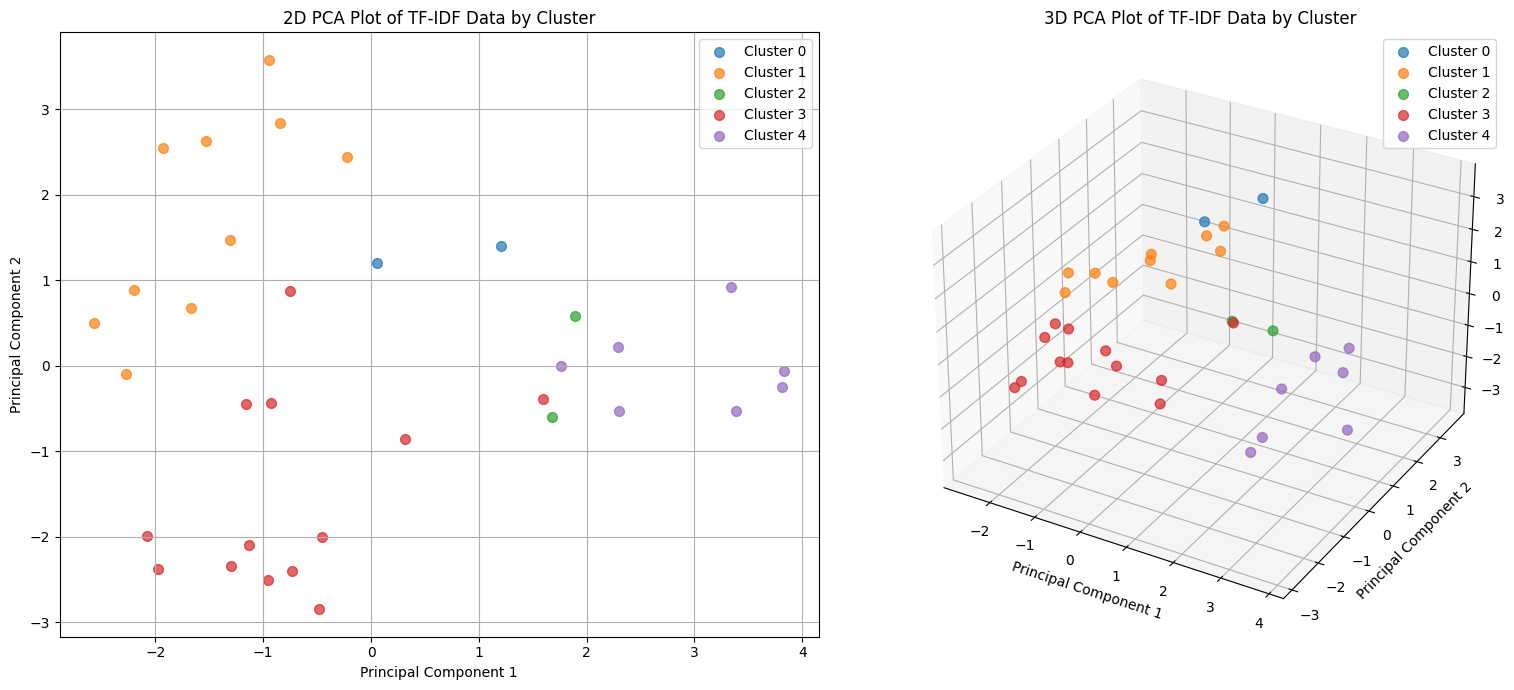

In [9]:
# 2D PCA 수행
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(tfidf_scaled)

# 3D PCA 수행
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(tfidf_scaled)

# 플롯 설정
fig = plt.figure(figsize=(16, 7))

# 2D PCA 서브플롯
ax1 = fig.add_subplot(121)  # 1행 2열 첫 번째 플롯
unique_clusters = set(tfidf_cluster['cluster'])
for cluster in unique_clusters:
    cluster_points = pca_result_2d[tfidf_cluster['cluster'] == cluster]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', s=50, alpha=0.7)

# 2D 플롯 설정
ax1.set_title("2D PCA Plot of TF-IDF Data by Cluster")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.legend()
ax1.grid(True)

# 3D PCA 서브플롯
ax2 = fig.add_subplot(122, projection='3d')  # 1행 2열 두 번째 플롯 (3D)
for cluster in unique_clusters:
    cluster_points = pca_result_3d[tfidf_cluster['cluster'] == cluster]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster}', s=50, alpha=0.7)

# 3D 플롯 설정
ax2.set_title("3D PCA Plot of TF-IDF Data by Cluster")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
ax2.legend()

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

##### 군집에 포함된 관광지 확인

In [10]:
cluster_places = blog_df.groupby('cluster')['place'].apply(list).reset_index()
pd.set_option('display.max_colwidth', None)
cluster_places[['place']]

,place
0,"[상상아트홀, 아신극장/1관]"
1,"[문창시장, 보문산, 산성시장, 성심당문화원, 스카이로드, 우리들공원, 유천시장, 으능정이문화거리, 중앙로지하상가, 태평시장]"
2,"[대전예술가의집, 테미예술창작센터]"
3,"[대전목재문화체험장, 대전아쿠아리움, 대전오월드, 대전음악창작소, 뿌리공원, 사정공원, 서대전공원, 양지근린공원, 중촌시민공원, 커먼즈필드/대전, 테미공원, 한화생명이글스파크, 형통사]"
4,"[대전근현대사전시관, 대전보훈공원, 대전형무소, 봉소루, 유회당, 창계숭절사, 테미오래]"


In [11]:
pd.reset_option('display.max_colwidth')

##### 군집 별 상위 빈도수 단어 확인

In [12]:
# 클러스터별로 많이 나온 단어 추출
def extract_top_words_by_cluster(df, num_words=100):
    cluster_top_words = {}

    for cluster, group in df.groupby('cluster'):
        all_adjectives = ' '.join(group['token'].tolist())
        words = all_adjectives.split() 

        # 단어 빈도 계산
        word_counts = Counter(words)
        # 가장 많이 나온 단어 num_words개 추출
        top_words = word_counts.most_common(num_words)
        # 클러스터별로 저장
        cluster_top_words[cluster] = top_words

    return cluster_top_words

# 결과 추출
top_words_by_cluster = extract_top_words_by_cluster(blog_df)

# 클러스터별 상위 10개 단어 출력
for cluster, top_words in top_words_by_cluster.items():
    print(f"Cluster {cluster}: {top_words}")

Cluster 0: [('연극', 964), ('공연', 547), ('알다', 424), ('보다', 399), ('좋다', 283), ('수', 272), ('배우', 256), ('재생', 256), ('관람', 234), ('층', 200), ('더', 182), ('것', 167), ('지도', 156), ('할인', 155), ('오다', 133), ('밤', 130), ('시작', 127), ('시간', 120), ('티켓', 116), ('예매', 116), ('완벽하다', 115), ('나', 113), ('보기', 111), ('중구', 110), ('이야기', 107), ('로맨스', 106), ('받다', 101), ('많다', 99), ('관객', 97), ('뮤지컬', 97), ('음소거', 96), ('설정', 96), ('해상도', 96), ('종로', 95), ('무대', 88), ('사진', 87), ('들다', 87), ('가다', 87), ('데이트', 85), ('진행', 84), ('사람', 84), ('예약', 84), ('후', 81), ('때', 80), ('네이버', 78), ('꼭', 77), ('저', 76), ('날', 76), ('친구', 75), ('포토', 75), ('좌석', 74), ('데이터', 73), ('컨트롤러', 73), ('범례', 73), ('부동산', 73), ('읍', 73), ('입장', 72), ('이', 72), ('보고', 71), ('사용', 71), ('찍다', 70), ('기본', 70), ('알', 70), ('고스트', 70), ('가능하다', 69), ('분', 69), ('생각', 68), ('추천', 67), ('장소', 66), ('별', 66), ('캠핑', 66), ('괴담', 66), ('곳', 64), ('자막', 64), ('속도', 64), ('도움말', 64), ('금', 64), ('앞', 64), ('빛나다', 63), ('고민', 63), ('

### 관광지 추천 대시보드

In [13]:
pop = pd.read_csv("../data/result/final.csv")

place_cluster = blog_df.groupby('cluster')['place'].apply(lambda x: pd.Series(x)).reset_index(level=0)
place_cluster.columns = ['군집', 'place']

pop_cluster = pd.merge(pop, place_cluster, left_on='관광지명', right_on='place', how='left')
pop_cluster = pop_cluster.drop(['place'], axis=1)
pd.set_option('display.max_colwidth', None)

##### 대시보드 생성

In [14]:
# 대시보드 앱 생성
app = Dash(__name__)

# 성별, 연령대, 시간대 옵션
genders = ['남성', '여성']
ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대이상']
times = ['오전', '점심', '오후', '저녁', '심야']

# 군집별 설명
cluster_descriptions = {
    0: "1. 연극과 공연을 즐길 수 있는 곳",
    1: "2. 맛집, 먹거리가 많은 곳",
    2: "3. 작품과 전시를 관람할 수 있는 곳",
    3: "4. 아이와 같이 가기 좋은 볼거리가 많은 곳",
    4: "5. 역사를 느낄 수 있는 곳"
}

# 대시보드 레이아웃 정의
app.layout = html.Div(children=[
    html.H1(children="대전 중구 관광지 추천", style={'textAlign': 'center'}),
    
    html.Div(children=[
        html.Label('성별을 선택하세요'),
        dcc.Dropdown(id='gender', options=[{'label': g, 'value': g} for g in genders], value=None),
        
        html.Label('연령대를 선택하세요'),
        dcc.Dropdown(id='age', options=[{'label': a, 'value': a} for a in ages], value=None),
        
        html.Label('시간대를 선택하세요'),
        dcc.Dropdown(id='time', options=[{'label': t, 'value': t} for t in times], value=None),
        
        html.Label('날짜를 입력하세요 (yyyy-mm-dd)'),
        dcc.Input(id='date', type='text', value=None),
        
        html.Button('제출', id='submit-button', n_clicks=0)  # 제출 버튼 추가
    ]),
    
    html.Div(id='filtered-data', style={'margin-top': '20px'})  # 결과 출력 영역
])

# 콜백 정의
@app.callback(
    Output('filtered-data', 'children'),
    Input('submit-button', 'n_clicks'),
    Input('gender', 'value'),
    Input('age', 'value'),
    Input('time', 'value'),
    Input('date', 'value')
)
def update_filtered_data(n_clicks, gender, age, time, date):
    # 입력된 날짜가 유효한지 확인
    try:
        if date and len(date) == 10:  # 'yyyy-mm-dd' 형식 확인
            date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
        else:
            return ""
    except ValueError:
        return ""

    # 사용자가 모든 선택을 완료하기 전에는 아무것도 표시하지 않음
    if not (n_clicks > 0 and gender and age and time and date):
        return ""

    # 휴일 또는 평일 계산
    kr_holidays = holidays.KR()
    holiday = '휴일' if date_obj.weekday() >= 5 or date_obj in kr_holidays else '평일'

    # 계절 계산
    month = date_obj.month
    if month in [3, 4, 5]:
        season = '봄'
    elif month in [6, 7, 8]:
        season = '여름'
    elif month in [9, 10, 11]:
        season = '가을'
    else:
        season = '겨울'
    
    # 필터링할 컬럼 이름 생성
    value = f"{season}_{gender}_{age}_{holiday}_{time}"
    
    # 데이터 필터링 및 순위 계산
    filtered_data = pop_cluster[['관광지명', '도로명주소', '군집', value]].copy()
    filtered_data['순위'] = filtered_data.groupby('군집')[value].rank(ascending=False)
    filtered_data = filtered_data.sort_values(by=['군집', '순위'], ascending=[True, True])

    # 군집별로 최대 2개의 관광지명과 주소 출력
    result = []
    for cluster, description in cluster_descriptions.items():
        # 해당 군집에 해당하는 데이터 필터링
        cluster_data = filtered_data[filtered_data['군집'] == cluster].head(2)

        if not cluster_data.empty:
            result.append(html.H3(description))
            result.append(html.Table([
                html.Thead(html.Tr([html.Th("관광지명"), html.Th("주소")])),  # 수정된 부분: html.Thead에 대한 괄호 맞춤
                html.Tbody([
                    html.Tr([
                        html.Td(cluster_data.iloc[i]['관광지명'], style={'padding-right': '20px'}),  # 관광지명과 주소 사이에 패딩 추가
                        html.Td(cluster_data.iloc[i]['도로명주소'])
                    ])
                    for i in range(len(cluster_data))
                ])
            ]))
            result.append(html.Br())  # 군집별 결과 사이에 줄바꿈 추가

    return result

# 앱 실행
if __name__ == '__main__':
    app.run_server(debug=True)